## Imports

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics

# Questions?

## Morning shift MS (until 11 am) and evening shift ES (after 4 pm)  
## What to do with: 11:30, 12:00, 12:30, 13:00, 13:30, 14:00?  
11:30     44361
12:00     41943
12:30     31465
13:00     21886
13:30     12276
14:00     11780

## Predict shift and num_pickups? or just num_pickups?

## Loading data

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [3]:
demand = pd.read_csv('data/demand.csv', parse_dates=['day'], index_col='day',date_parser=dateparse)

In [4]:
supply = pd.read_csv('data/supply.csv', parse_dates=['day'], index_col='day',date_parser=dateparse)

In [5]:
demand.head()

,shift,num_pickups
day,,
2018-08-08,MS,61
2018-02-14,MS,75
2018-05-09,MS,110
2018-06-04,MS,67
2018-07-03,MS,59


In [6]:
len(demand)

223

## Visualizing data and looking for stationarity

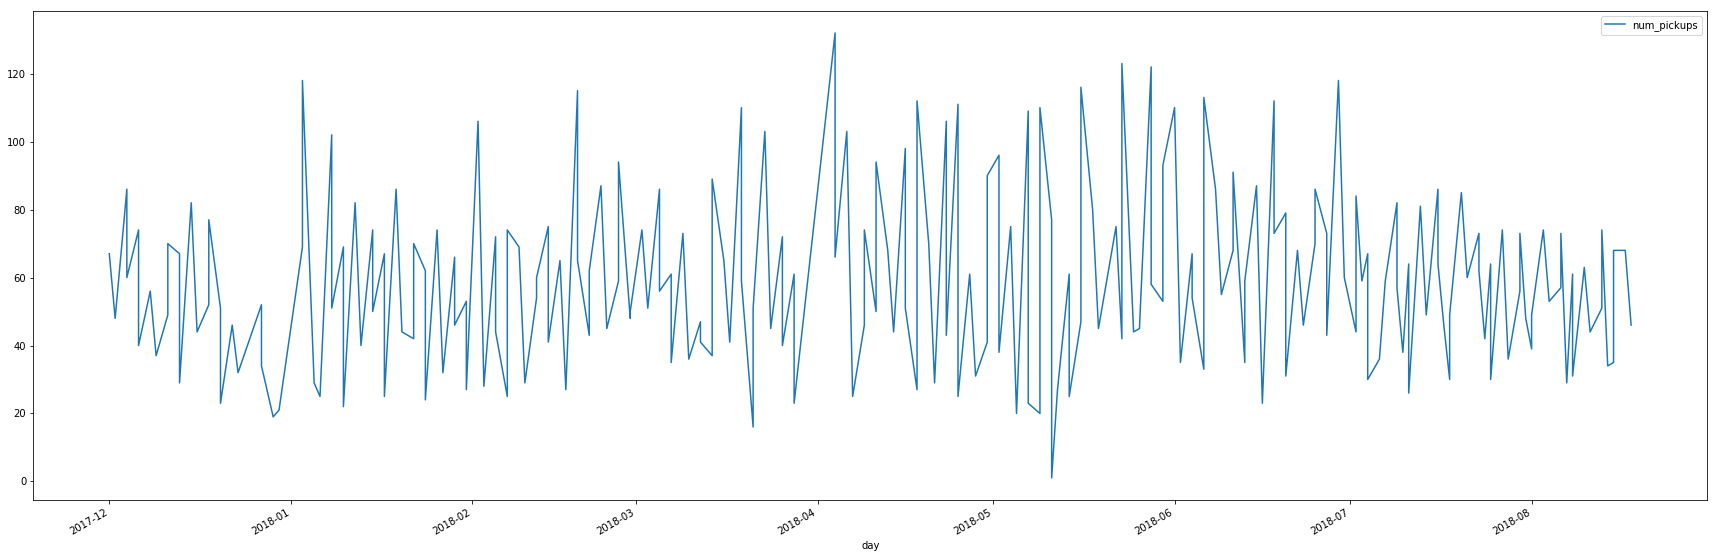

In [7]:
# Plot number of pickups to check if the series is stationary as most of the TS models work on the assumption that the TS is stationary
demand.plot(figsize=(30,10))
plt.show()

stationary:  
mean should be constant  
variance should not be a function  
covariance of i and i+n should not be a function  

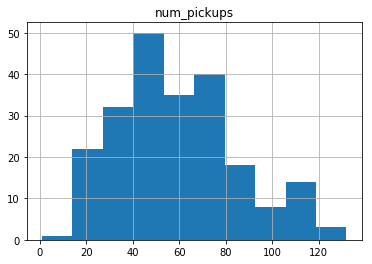

In [8]:
demand.hist()
plt.show()

Gaussian distribution

In [9]:
demand.sort_values('day').head()

,shift,num_pickups
day,,
2017-12-01,MS,67
2017-12-02,MS,48
2017-12-04,MS,86
2017-12-04,ES,60
2017-12-06,MS,74


In [10]:
demand.sort_values('day').tail()

,shift,num_pickups
day,,
2018-08-14,MS,34
2018-08-15,ES,35
2018-08-15,MS,68
2018-08-17,MS,68
2018-08-18,MS,46


In [11]:
# Hälfte bei Dienstag, 10. April 2018
demand_data = demand
demand_data1, demand_data2 = demand_data[:'2018-04-10'], demand_data['2018-04-10':]
mean1, mean2 = demand_data1.num_pickups.mean(), demand_data2.num_pickups.mean()
var1, var2 = demand_data1.var(), demand_data2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=56.923077, mean2=60.957983
variance1=596.479462, variance2=702.193135


mean and variance are pretty similar from the first and second half of the data.  
--> indication of stationary data.  

In [12]:
from statsmodels.tsa.stattools import adfuller

demand_data_adf = demand['num_pickups'].values
result_adf = adfuller(demand_data_adf)
print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.459466
p-value: 0.000000
Critical Values:
	1%: -3.460
	5%: -2.875
	10%: -2.574


p-value > 0.05: the data has a unit root and is non-stationary  
p-value ≤ 0.05: the data does not have a unit root and is stationary  
here stationary

## Visualizing timeslots

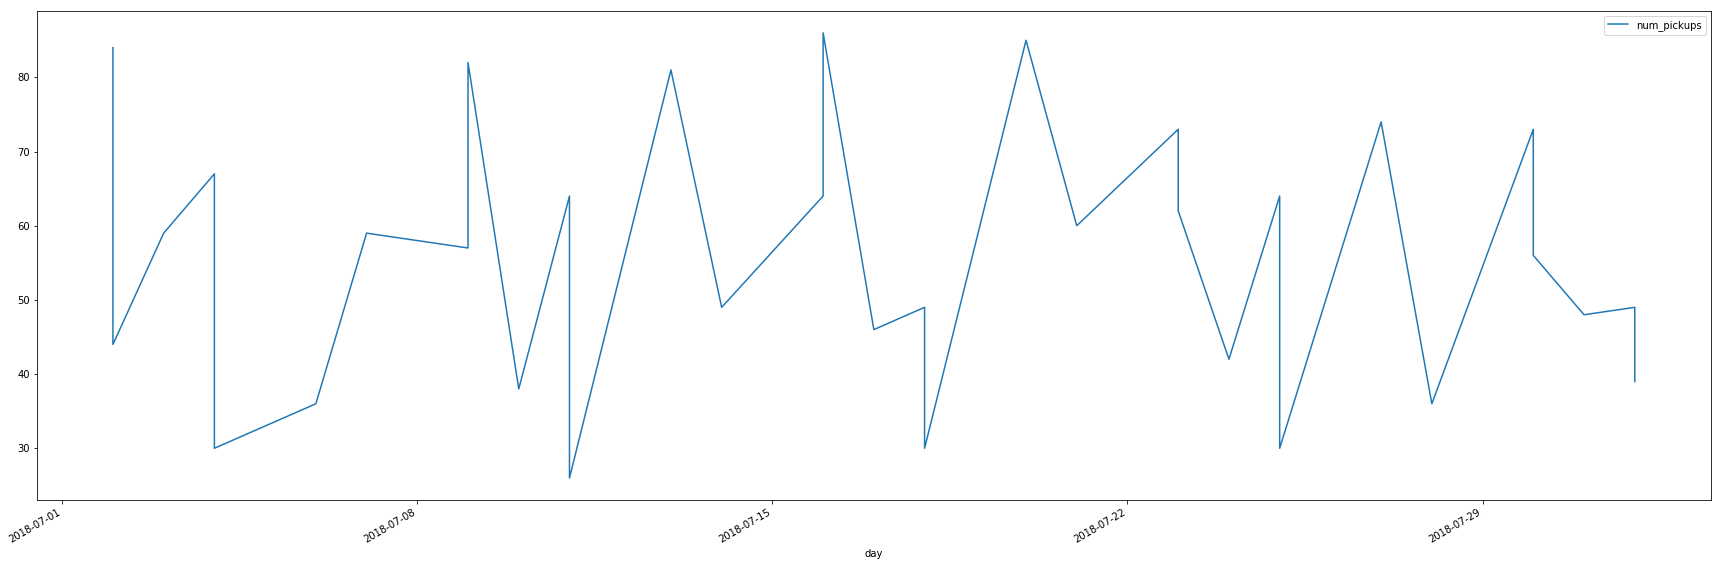

In [13]:
demand['2018-07-01':'2018-08-01'].plot(figsize=(30,10))
plt.show()

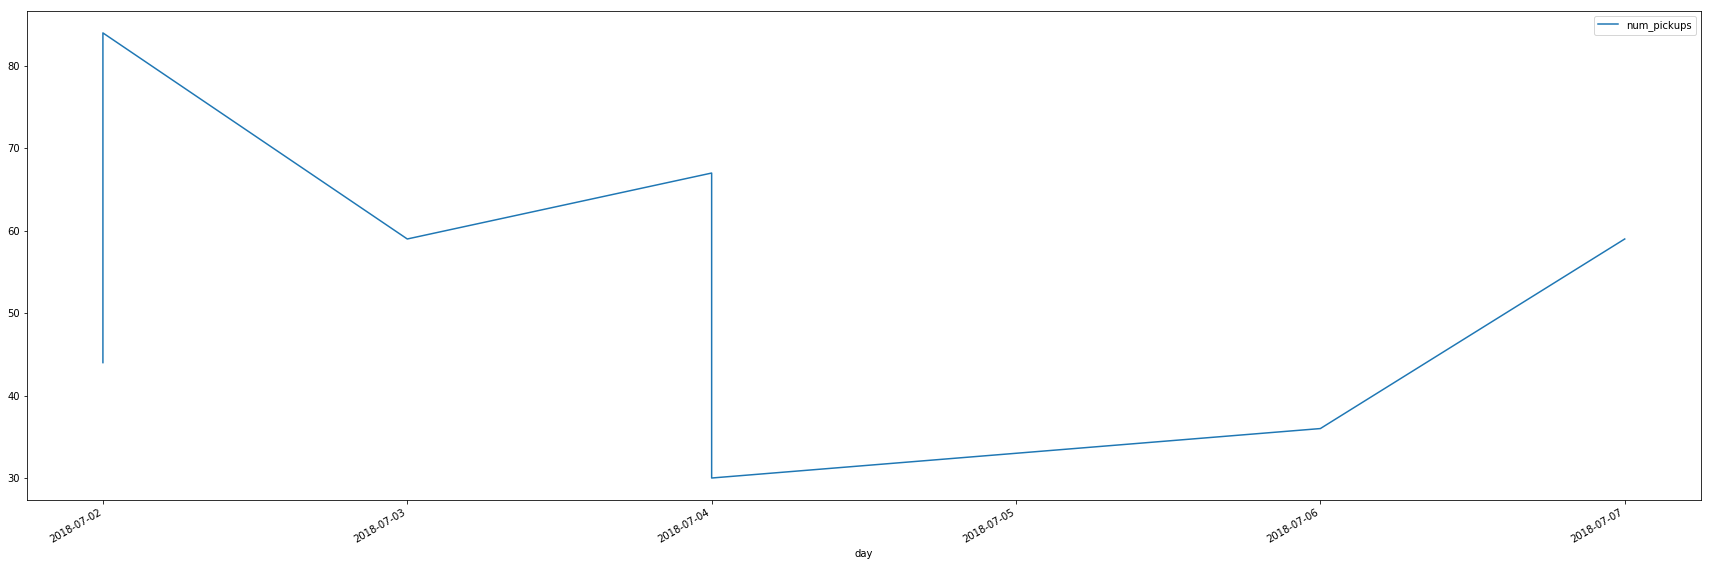

In [14]:
demand['2018-07-01':'2018-07-07'].plot(figsize=(30,10))
plt.show()

7.2 Montag
7.7 Samstag

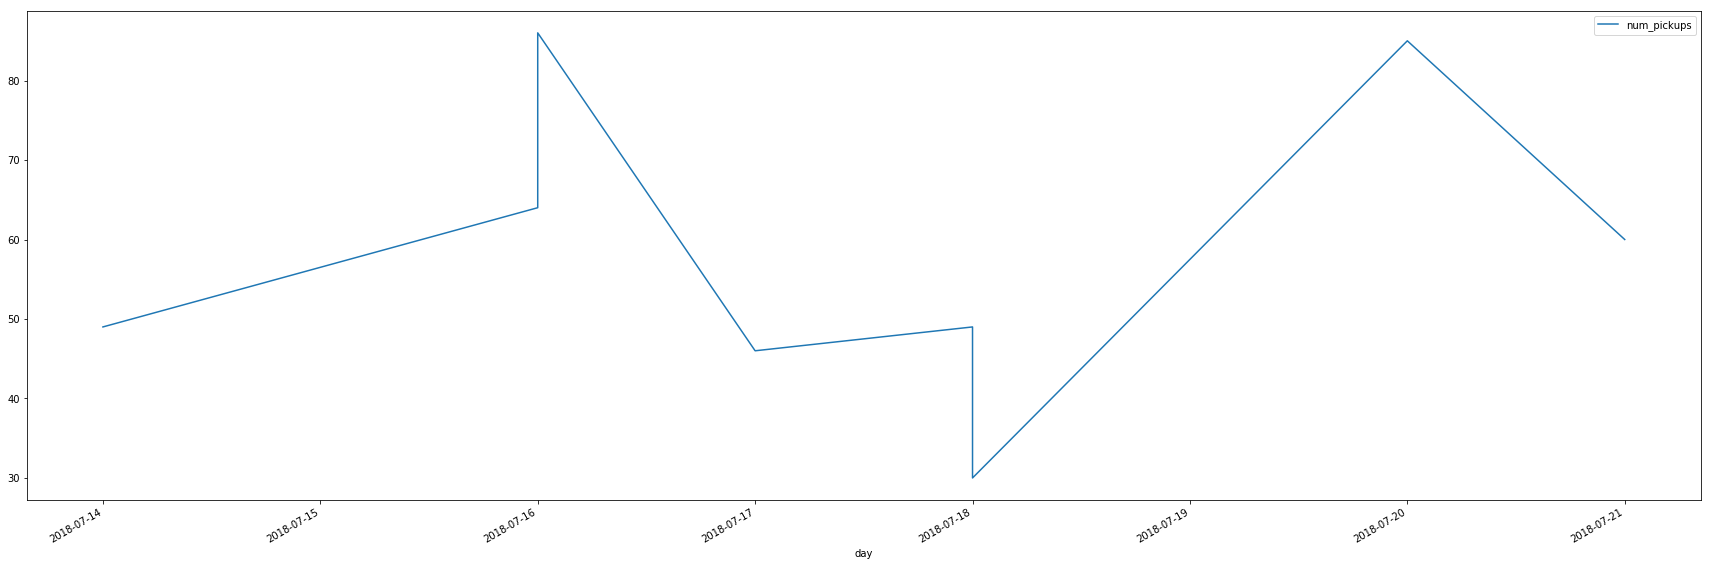

In [15]:
demand['2018-07-14':'2018-07-21'].plot(figsize=(30,10))
plt.show()

## Summarizing Data

In [16]:
supply.head()

,timeslot_from,calculated_datetime,grid_unit,avail_area_ratio
day,,,,
2018-01-08,05:30,2017-12-20 16:00:04,1,0.00
2018-01-08,06:00,2017-12-20 16:00:04,1,0.37
2018-01-08,06:00,2018-01-03 07:05:44,1,0.37
2018-01-08,06:00,2018-01-03 08:14:53,1,0.37
2018-01-08,06:00,2018-01-03 08:16:26,1,0.37


In [17]:
demand.head()

,shift,num_pickups
day,,
2018-08-08,MS,61
2018-02-14,MS,75
2018-05-09,MS,110
2018-06-04,MS,67
2018-07-03,MS,59


In [18]:
len(demand)

223

In [19]:
len(supply)

5082605

In [20]:
supply.nunique()

timeslot_from             37
calculated_datetime    19366
grid_unit                 31
avail_area_ratio          21
dtype: int64

In [21]:
demand.describe()

,num_pickups
count,223.000000
mean,59.076233
std,25.574454
min,1.000000
25%,41.000000
50%,57.000000
75%,74.000000
max,132.000000


In [22]:
demand.isnull().values.any()

False

In [23]:
supply.isnull().values.any()

False

In [24]:
supply.timeslot_from.unique()

array(['05:30', '06:00', '06:30', '07:00', '07:30', '08:00', '08:30',
       '09:00', '09:30', '10:00', '10:30', '17:00', '17:30', '18:00',
       '18:30', '19:00', '19:30', '20:00', '20:30', '21:00', '21:30',
       '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00',
       '14:30', '15:00', '15:30', '16:00', '16:30', '22:00', '22:30',
       '23:00', '23:30'], dtype=object)

In [25]:
demand['shift'].value_counts()

MS    152
ES     71
Name: shift, dtype: int64

## Add shift unit to Supply

In [26]:
supply['hour'] = pd.to_datetime(supply['timeslot_from'], format='%H:%M')

In [27]:
supply['shift'] = list(map(lambda x: 'MS' if x.hour < 11 else('ES' if x.hour> 16 else np.NaN), supply['hour']))

In [28]:
supply.head()

,timeslot_from,calculated_datetime,grid_unit,avail_area_ratio,hour,shift
day,,,,,,
2018-01-08,05:30,2017-12-20 16:00:04,1,0.00,1900-01-01 05:30:00,MS
2018-01-08,06:00,2017-12-20 16:00:04,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 07:05:44,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:14:53,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:16:26,1,0.37,1900-01-01 06:00:00,MS


In [29]:
len(supply['2018-01-08':'2018-01-09'])

31899

In [30]:
len(supply)

5082605

In [31]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
supply['2018-01-08':'2018-01-09']

,timeslot_from,calculated_datetime,grid_unit,avail_area_ratio,hour,shift
day,,,,,,
2018-01-08,05:30,2017-12-20 16:00:04,1,0.00,1900-01-01 05:30:00,MS
2018-01-08,06:00,2017-12-20 16:00:04,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 07:05:44,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:14:53,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:16:26,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 10:33:31,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-04 07:35:26,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-05 07:39:47,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-05 09:36:17,1,0.25,1900-01-01 06:00:00,MS


## Shift demand

In [32]:
demand = demand
demand.head()

,shift,num_pickups
day,,
2018-08-08,MS,61
2018-02-14,MS,75
2018-05-09,MS,110
2018-06-04,MS,67
2018-07-03,MS,59


In [33]:
ms_demands = demand[demand['shift'] == 'MS'].sort_index()
for i in range(1, 8):
    ms_demands["pickups-{}".format(i)] = ms_demands.num_pickups.shift(i)
ms_demands.head()

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7
day,,,,,,,,,
2017-12-01,MS,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-02,MS,48,67.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,MS,86,48.0,67.0,NaN,NaN,NaN,NaN,NaN
2017-12-06,MS,74,86.0,48.0,67.0,NaN,NaN,NaN,NaN
2017-12-08,MS,56,74.0,86.0,48.0,67.0,NaN,NaN,NaN


In [34]:
es_demands = demand[demand['shift'] == 'ES'].sort_index()
for i in range(1, 8):
    es_demands["pickups-{}".format(i)] = es_demands.num_pickups.shift(i)
es_demands.head()

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7
day,,,,,,,,,
2017-12-04,ES,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-06,ES,40,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-11,ES,49,40.0,60.0,NaN,NaN,NaN,NaN,NaN
2017-12-13,ES,29,49.0,40.0,60.0,NaN,NaN,NaN,NaN
2017-12-18,ES,52,29.0,49.0,40.0,60.0,NaN,NaN,NaN


In [35]:
demands2 = pd.concat([ms_demands, es_demands])

In [36]:
demands2 = demands2.sort_index()
demands2.head(10)

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7
day,,,,,,,,,
2017-12-01,MS,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-02,MS,48,67.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,ES,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,MS,86,48.0,67.0,NaN,NaN,NaN,NaN,NaN
2017-12-06,MS,74,86.0,48.0,67.0,NaN,NaN,NaN,NaN
2017-12-06,ES,40,60.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-08,MS,56,74.0,86.0,48.0,67.0,NaN,NaN,NaN
2017-12-09,MS,37,56.0,74.0,86.0,48.0,67.0,NaN,NaN
2017-12-11,MS,70,37.0,56.0,74.0,86.0,48.0,67.0,NaN


In [37]:
demands2.isna().sum()

shift           0
num_pickups     0
pickups-1       2
pickups-2       4
pickups-3       6
pickups-4       8
pickups-5      10
pickups-6      12
pickups-7      14
dtype: int64

In [38]:
len(demands2)

223

In [39]:
demand_feature = demands2.dropna()

In [40]:
len(demand_feature)

209

## Features supply

In [41]:
supply.head()

,timeslot_from,calculated_datetime,grid_unit,avail_area_ratio,hour,shift
day,,,,,,
2018-01-08,05:30,2017-12-20 16:00:04,1,0.00,1900-01-01 05:30:00,MS
2018-01-08,06:00,2017-12-20 16:00:04,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 07:05:44,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:14:53,1,0.37,1900-01-01 06:00:00,MS
2018-01-08,06:00,2018-01-03 08:16:26,1,0.37,1900-01-01 06:00:00,MS


In [42]:
supply['calculated_datetime'] = pd.to_datetime(supply['calculated_datetime'])

In [43]:
#supply2 = supply.drop(columns=['timeslot_from', 'hour'])

In [44]:
#supply2.groupby(['day', 'shift', 'grid_unit']).last().head(100)

In [45]:
type(supply['calculated_datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
ms_feature_per_day = pd.DataFrame(data=supply.index.unique())

In [47]:
type(ms_feature_per_day.day[0])

pandas._libs.tslibs.timestamps.Timestamp

In [48]:
ms_supply = supply[supply['shift'] == 'MS'].sort_index()

In [49]:
ms_supply_grouped = ms_supply.groupby(['day'])

In [50]:
ms_mean_avail_area_of_day = []
for day, group in ms_supply_grouped:
    m = group['avail_area_ratio'].mean()
    ms_mean_avail_area_of_day.append(m)

In [51]:
ms_supply.index.nunique()

189

In [52]:
len(ms_mean_avail_area_of_day) # 189 Tage * 31 Grids = 5859

189

In [53]:
ms_mean_avail_area_of_day

[0.0,
 0.40442415084422834,
 0.3272483120780195,
 0.19753225806451613,
 0.3248547016357489,
 0.35712256758521616,
 0.39118162692847125,
 0.15693010752688172,
 0.4687273273498817,
 0.4391764237355635,
 0.4821079404466502,
 0.21211834805835214,
 0.43450860657551216,
 0.4770996339510409,
 0.5119778567523238,
 0.17114340466304692,
 0.46320508594301857,
 0.40632704780722473,
 0.3550057603686636,
 0.1640423387096774,
 0.46976159274193546,
 0.30752586731588555,
 0.38838332390115077,
 0.22777126099706743,
 0.376724892685622,
 0.43951360323302296,
 0.3879711672375503,
 0.17554204124801692,
 0.4848800380367201,
 0.34867175535406086,
 0.42049609253967707,
 0.2269216589861751,
 0.4630973297683947,
 0.33905513110733826,
 0.5399833147942158,
 0.2470506912442396,
 0.5217974553399306,
 0.40501502704868764,
 0.39403543933320606,
 0.20381797235023041,
 0.37133834947570643,
 0.25850834330204175,
 0.2978106821787414,
 0.23520269104709338,
 0.42676235243460486,
 0.38968589345234733,
 0.4300103640367923,
 0

In [54]:
ms_feature_per_day['mean_avail_area_of_day'] = ms_mean_avail_area_of_day
ms_feature_per_day['shift'] = 'MS'

In [55]:
ms_feature_per_day.tail()

,day,mean_avail_area_of_day,shift
184,2018-08-21,0.0,MS
185,2018-08-28,0.0,MS
186,2018-09-04,0.0,MS
187,2018-09-11,0.0,MS
188,2018-09-18,0.0,MS


### Evening Shift

In [56]:
es_supply = supply[supply['shift'] == 'ES'].sort_index()
es_feature_per_day = pd.DataFrame(data=es_supply.index.unique())
es_supply_grouped = es_supply.groupby(['day'])

es_mean_avail_area_of_day = []
for day, group in es_supply_grouped:
    m_es = group['avail_area_ratio'].mean()
    es_mean_avail_area_of_day.append(m_es)

In [57]:
es_mean_avail_area_of_day

[0.0,
 0.29699727170598617,
 0.2914491161490063,
 0.25826654189144554,
 0.5138116250760804,
 0.37140161725067383,
 0.3824011220196354,
 0.4026738042269188,
 0.3813265306122449,
 0.289082895723931,
 0.0,
 0.0,
 0.2607499411349188,
 0.2846349110642147,
 0.0,
 0.0,
 0.26937642875285744,
 0.2550818858560794,
 0.0,
 0.0,
 0.19606208155812538,
 0.3023615877373599,
 0.0,
 0.0,
 0.3611721494730118,
 0.30068957009806946,
 0.0,
 0.0,
 0.3153992918961448,
 0.36915150363437693,
 0.0,
 0.0,
 0.25056603773584907,
 0.1842156981192864,
 0.0,
 0.0,
 0.4689124923507299,
 0.1979460269865067,
 0.0,
 0.0,
 0.35810185185185184,
 0.3737589698880021,
 0.0,
 0.0,
 0.0,
 0.2862495422617265,
 0.0,
 0.0,
 0.23552845528455282,
 0.42866184226665033,
 0.0,
 0.0,
 0.5104543010752688,
 0.3726032823995472,
 0.0,
 0.0,
 0.33402066425697335,
 0.24269634104639237,
 0.0,
 0.0,
 0.2316385048643113,
 0.2421917181423015,
 0.0,
 0.0,
 0.19800596307205978,
 0.25629272477693893,
 0.3526344086021505,
 0.0,
 0.2776721399489956,
 0

In [58]:
len(es_mean_avail_area_of_day)

168

In [59]:
len(es_feature_per_day)

168

In [60]:
es_feature_per_day['mean_avail_area_of_day'] = es_mean_avail_area_of_day
es_feature_per_day['shift'] = 'ES'

### concat features

In [61]:
feature_per_day = pd.concat([ms_feature_per_day, es_feature_per_day])

In [62]:
len(feature_per_day)

357

## Merge supply and demand

In [63]:
len(demand_feature)

209

In [64]:
len(feature_per_day)

357

In [65]:
demand_feature.head()

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7
day,,,,,,,,,
2017-12-13,MS,67,70.0,37.0,56.0,74.0,86.0,48.0,67.0
2017-12-15,MS,82,67.0,70.0,37.0,56.0,74.0,86.0,48.0
2017-12-16,MS,44,82.0,67.0,70.0,37.0,56.0,74.0,86.0
2017-12-18,MS,77,44.0,82.0,67.0,70.0,37.0,56.0,74.0
2017-12-20,MS,51,77.0,44.0,82.0,67.0,70.0,37.0,56.0


In [66]:
feature_per_day.head()

,day,mean_avail_area_of_day,shift
0,2018-01-08,0.000000,MS
1,2018-01-10,0.404424,MS
2,2018-01-05,0.327248,MS
3,2018-01-03,0.197532,MS
4,2018-01-20,0.324855,MS


In [67]:
features_and_target = pd.merge(demand_feature, feature_per_day, on=['day', 'shift'], how='left')

In [68]:
features_and_target.head(20)

,day,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day
0,2017-12-13,MS,67,70.0,37.0,56.0,74.0,86.0,48.0,67.0,NaN
1,2017-12-15,MS,82,67.0,70.0,37.0,56.0,74.0,86.0,48.0,NaN
2,2017-12-16,MS,44,82.0,67.0,70.0,37.0,56.0,74.0,86.0,NaN
3,2017-12-18,MS,77,44.0,82.0,67.0,70.0,37.0,56.0,74.0,NaN
4,2017-12-20,MS,51,77.0,44.0,82.0,67.0,70.0,37.0,56.0,NaN
5,2017-12-22,MS,46,51.0,77.0,44.0,82.0,67.0,70.0,37.0,NaN
6,2017-12-23,MS,32,46.0,51.0,77.0,44.0,82.0,67.0,70.0,NaN
7,2017-12-27,MS,52,32.0,46.0,51.0,77.0,44.0,82.0,67.0,NaN
8,2017-12-29,MS,19,52.0,32.0,46.0,51.0,77.0,44.0,82.0,NaN
9,2017-12-30,MS,21,19.0,52.0,32.0,46.0,51.0,77.0,44.0,NaN


In [69]:
len(features_and_target)

209

In [70]:
features_and_target = features_and_target.fillna(0)

In [71]:
features_and_target = features_and_target.set_index('day')

In [72]:
features_and_target = features_and_target.sort_values('day')

In [73]:
features_and_target.sort_values('day').head(1)

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day
day,,,,,,,,,,
2017-12-13,MS,67,70.0,37.0,56.0,74.0,86.0,48.0,67.0,0.0


In [74]:
features_and_target.sort_values('day').tail(1)

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day
day,,,,,,,,,,
2018-08-18,MS,46,68.0,68.0,34.0,74.0,44.0,63.0,61.0,0.552697


## Train Test Validation Split

### 253 = 80/20 = 202/51 -> 2018-06-28

In [75]:
shift = pd.get_dummies(features_and_target['shift'])

In [76]:
shift.head()

,ES,MS
day,,
2017-12-13,0,1
2017-12-15,0,1
2017-12-16,0,1
2017-12-18,0,1
2017-12-20,0,1


In [77]:
features_and_target.head()

,shift,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day
day,,,,,,,,,,
2017-12-13,MS,67,70.0,37.0,56.0,74.0,86.0,48.0,67.0,0.0
2017-12-15,MS,82,67.0,70.0,37.0,56.0,74.0,86.0,48.0,0.0
2017-12-16,MS,44,82.0,67.0,70.0,37.0,56.0,74.0,86.0,0.0
2017-12-18,MS,77,44.0,82.0,67.0,70.0,37.0,56.0,74.0,0.0
2017-12-20,MS,51,77.0,44.0,82.0,67.0,70.0,37.0,56.0,0.0


In [78]:
len(features_and_target)

209

In [79]:
features_and_target['ES'] = shift.ES
features_and_target['MS'] = shift.MS
features_and_target = features_and_target.drop('shift', axis=1)

In [80]:
train_test = features_and_target[:'2018-06-28']
validation = features_and_target['2018-06-28':]

In [81]:
train = train_test[:'2018-05-19']
test = train_test['2018-05-19':]

In [82]:
len(train)

125

In [83]:
len(test)

34

In [84]:
len(validation)

51

In [85]:
train.head()

,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day,ES,MS
day,,,,,,,,,,,
2017-12-13,67,70.0,37.0,56.0,74.0,86.0,48.0,67.0,0.0,0,1
2017-12-15,82,67.0,70.0,37.0,56.0,74.0,86.0,48.0,0.0,0,1
2017-12-16,44,82.0,67.0,70.0,37.0,56.0,74.0,86.0,0.0,0,1
2017-12-18,77,44.0,82.0,67.0,70.0,37.0,56.0,74.0,0.0,0,1
2017-12-20,51,77.0,44.0,82.0,67.0,70.0,37.0,56.0,0.0,0,1


In [86]:
y = train['num_pickups'].values
train = train.drop('num_pickups', axis=1)

In [87]:
y_test = test['num_pickups'].values
test = test.drop('num_pickups', axis=1)

In [88]:
y_val = validation['num_pickups'].values
val = validation.drop('num_pickups', axis=1)

## Train

In [149]:
from sklearn.ensemble import RandomForestRegressor
# fit random forest model
model = RandomForestRegressor(max_depth=7, min_samples_leaf=35, random_state=1)
model.fit(train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=35, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [150]:
from sklearn import metrics
predictionsT = model.predict(train)
errorT = metrics.mean_squared_error(predictionsT, y)
rmseT = np.sqrt(errorT)
print(rmseT)

22.338588664654786


## Test

In [151]:
from sklearn import metrics
predictions = model.predict(test)
error = metrics.mean_squared_error(predictions, y_test)
rmse = np.sqrt(error)
print(rmse)

22.868096619879953


In [154]:
from sklearn import metrics
l =[]
for i in range(len(test)):
    l.append(y.mean())
mse = metrics.mean_squared_error(y_test, l)
rmse = np.sqrt(mse)
print(rmse)

28.5982715726174


In [97]:
feature_importances = pd.DataFrame(data= { 'feature_importance_values':
                                          model.feature_importances_}, index=train.columns.values)
feature_importances.sort_values('feature_importance_values')

,feature_importance_values
MS,0.012713
ES,0.018786
pickups-6,0.025527
pickups-7,0.045009
pickups-1,0.052808
pickups-5,0.065678
pickups-3,0.075607
pickups-2,0.077294
mean_avail_area_of_day,0.227834
pickups-4,0.398744


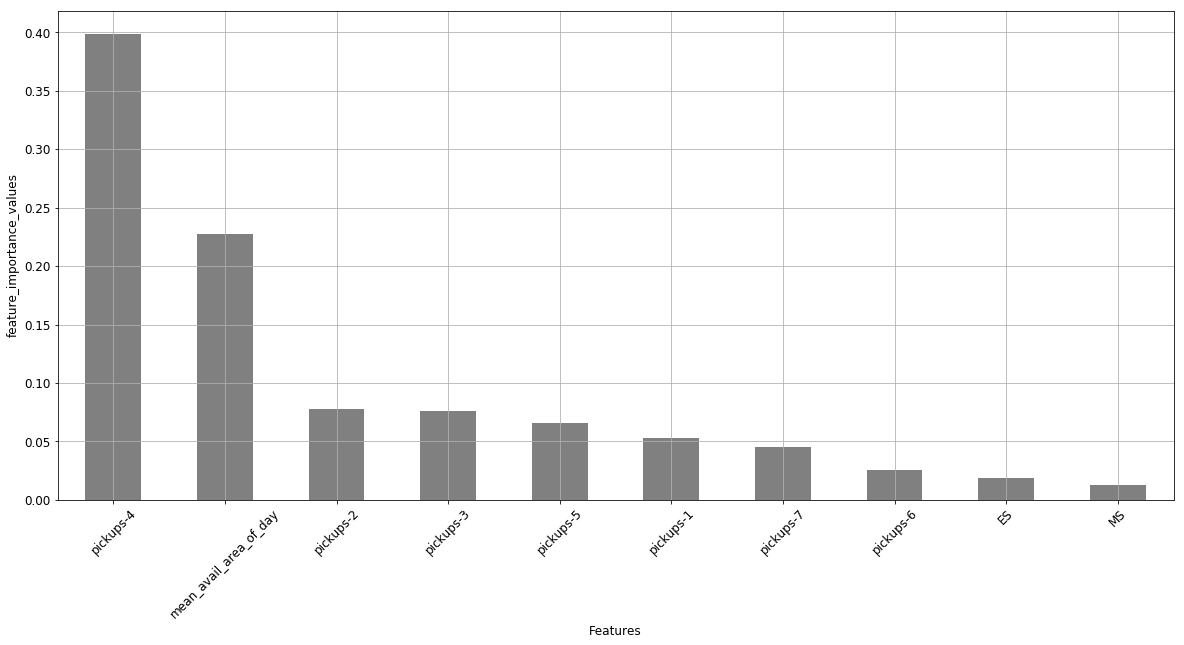

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plot = feature_importances.feature_importance_values.sort_values(ascending=False).plot(capsize=5, legend=False, grid=True,color ='grey', kind='bar', figsize= (20,9))

for label in plot.get_xticklabels():
    label.set_rotation(45)

plot.set_ylabel('feature_importance_values')
plot.set_xlabel('Features')

plt.show()